# Análisis exploratorio de datos

En este trabajo se realiza un análisis básico de la información disponible en dos datasets diferentes, los cuales se acceden a través de `openml`.

In [1]:
# Importo pandas y pandas_profiling

#! pip install pandas_profiling==2.5.0
#! pip install openml

import pandas as pd
import openml
from pandas_profiling import ProfileReport

# Carga de los datasets elegidos

In [5]:
sel_datasets = (188, 17) # Resultado obtenido aleatoriamente

dataset_a = openml.datasets.get_dataset(sel_datasets[0])
dataset_b = openml.datasets.get_dataset(sel_datasets[1])

# Impresión de datos básicos

print(f'El primer dataset es "{dataset_a.name}"', 
      f"y su atributo principal es '{dataset_a.default_target_attribute}'.")

print('\n',f'El segundo dataset es "{dataset_b.name}"', 
      f"y su atributo principal es '{dataset_b.default_target_attribute}'.")

El primer dataset es "eucalyptus" y su atributo principal es 'Utility'.

 El segundo dataset es "bridges" y su atributo principal es 'TYPE'.


In [0]:
# Obtengo los arreglos en ambos, de la misma manera que en el ejercicio práctico

X_a, y_a, categorical_indicator_a, attribute_names_a = dataset_a.get_data(
    dataset_format='dataframe',
    target=dataset_a.default_target_attribute
)

X_b, y_b, categorical_indicator_b, attribute_names_b = dataset_b.get_data(
    dataset_format='dataframe',
    target=dataset_b.default_target_attribute
)

# Combino en ambos el arreglo con los datos con las distintas clases

combined_a = pd.concat([X_a, y_a], axis=1)
combined_b = pd.concat([X_b, y_b], axis=1)

# Análisis de los datasets

## Primer dataset: Árboles de eucalipto

### Información básica

En primer lugar, se muestra la información básica incluída en el dataset, y las primeras filas del mismo a través del método `head()`.

In [7]:
print('La cantidad total de filas en el dataset es de:', len(combined_a))

La cantidad total de filas en el dataset es de: 736


In [8]:
print(dataset_a.description[:500])

**Author**: Bruce Bulloch    
**Source**: [WEKA Dataset Collection](http://www.cs.waikato.ac.nz/ml/weka/datasets.html) - part of the agridatasets archive. [This is the true source](http://tunedit.org/repo/Data/Agricultural/eucalyptus.arff)  
**Please cite**: None  

**Eucalyptus Soil Conservation**  
The objective was to determine which seedlots in a species are best for soil conservation in seasonally dry hill country. Determination is found by measurement of height, diameter by height, surviva


In [9]:
combined_a.head()

,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,co,1520.0,18.45,9.96,40.0,4.0,3.0,3.5,4.0,3.5,good
1,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,fr,1487.0,13.15,9.65,90.0,4.5,4.0,3.5,3.5,3.0,best
2,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,ma,1362.0,10.32,6.50,50.0,2.3,2.5,3.0,3.5,3.0,low
3,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,nd,1596.0,14.80,9.48,70.0,3.7,3.0,3.3,4.0,3.5,good
4,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,ni,2088.0,14.50,10.78,90.0,4.0,2.7,3.3,3.0,3.0,good


En la última columna podemos ver el atributo principal **'Utility'**. Veamos cuántas y cuáles categorías puede tomar.

In [10]:
combined_a['Utility'].unique()

[good, best, low, average, none]
Categories (5, object): [none < low < average < good < best]

### Análisis estadístico y visualización de los datos

In [11]:
combined_a.describe().round(1)

,Rep,Altitude,Rainfall,Frosts,Year,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm
count,736.0,736.0,736.0,736.0,736.0,729.0,735.0,735.0,642.0,667.0,667.0,667.0,667.0,667.0
mean,2.0,172.0,1095.9,-2.6,1982.1,2054.7,72.9,9.3,59.7,3.1,2.9,3.0,3.2,2.8
std,1.1,59.2,144.8,0.5,1.6,618.4,1551.8,4.1,30.9,1.0,0.8,0.7,0.8,0.8
min,1.0,70.0,850.0,-3.0,1980.0,1.0,0.6,1.1,1.5,0.5,0.0,0.0,0.0,0.0
25%,1.0,150.0,1000.0,-3.0,1981.0,1522.0,8.1,6.1,38.0,2.5,2.5,2.5,3.0,2.5
50%,2.0,160.0,1080.0,-3.0,1982.0,2426.0,14.2,9.0,63.0,3.0,3.0,3.0,3.3,3.0
75%,3.0,180.0,1200.0,-2.0,1983.0,2569.0,20.8,11.9,88.0,4.0,3.5,3.5,4.0,3.3
max,22.0,300.0,1750.0,-2.0,1986.0,3275.0,42085.0,21.8,100.0,5.0,4.5,5.0,5.0,5.0


Con el método `describe()` obtenemos información sobre la distribución de valores en cada columna.

Se destaca la ausencia de ciertos valores, a partir de la columna **'PMCno'**, y especialmente en la columna **'Surv'**.

A continuación, hacemos una visualización de los datos, diferenciándolos de acuerdo a la categoría principal **'Utility'**. 

Dada la cantidad de columnas de este dataset, se opta por conservar únicamente las que refieren a la altura, supervivencia, resistencia a insectos y vigor de la planta. De esta manera se busca obtener un gráfico más conciso.

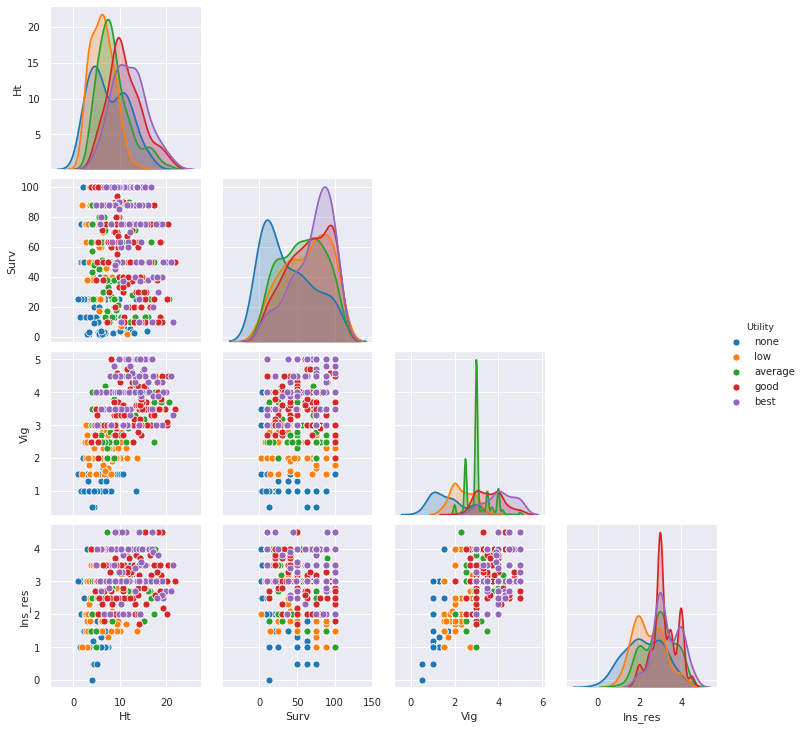

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

iris_plot_a = sns.pairplot(combined_a[['Utility', 'Ht', 'Surv', 'Vig', 'Ins_res']]
                         , hue='Utility')
iris_plot_a.map_upper(hide_current_axis)
plt.show()

Como fuera realizado en clase, obtenemos un `ProfileReport` del dataframe.

In [13]:
report_a = ProfileReport(combined_a)
report_a

Output hidden; open in https://colab.research.google.com to view.

Entre la cantidad de datos del reporte podemos observar: la cantidad de celdas faltantes totales (448); que se da una correlación esperable entre la locación (**'Abbrev'**), las heladas y otros datos de localización; que la distribución de la columna **'DBH'** está sesgada (*skewed*), quizás por información errónea; correlación positiva entre la altura y el vigor; idem para los atributos de forma.

### Preprocesamiento

En primer lugar, investigamos la columna **'DBH'** por lo indicado. Para esto buscamos cuántos valores superan cuatro veces el valor medio de esta.

In [14]:
combined_a['DBH'][combined_a['DBH']>4*combined_a['DBH'].mean()]

603    42085.0
Name: DBH, dtype: float64

Este valor representa un *outlier*, probablemente causado por un error dada la diferencia con el resto de los valores de la columna. Por esto, se opta por reemplazarlo por un `NaN`.

In [0]:
import numpy as np
combined_a.loc[603, 'DBH'] = np.nan

A continuación buscamos rellenar la información faltante (`NaN`) en el dataset. Por la información que el mismo representa queremos diferenciar por especie (**'Sp'**), la cantidad de valores existentes en cada columna (a partir de la columna **'PMCno'**, donde comienzan a registrarse valores faltantes).

In [16]:
combined_a.groupby(['Sp']).count().loc[:,'PMCno':]

,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
Sp,,,,,,,,,,
co,26,27,27,21,23,23,23,23,23,27
fr,52,52,52,49,52,52,52,52,52,52
ma,3,3,3,3,3,3,3,3,3,3
nd,85,85,86,67,70,70,70,70,70,86
ni,31,31,31,28,31,31,31,31,31,31
ob,50,50,50,48,50,50,50,50,50,50
ov,62,62,62,59,62,62,62,62,62,62
pu,38,39,39,26,29,29,29,29,29,39
rd,37,37,37,34,37,37,37,37,37,37


En caso de las especies registradas como *ra* y *te*, tenemos categorías completas sin datos. No se busca completar las mismas al no tener datos precisos, para el resto de los casos se busca rellenar los `NaN` con los valores medios de cada especie.

Se crea un nuevo dataframe (`df_a`) para realizar las modificaciones.

Aplicando el método `dropna()`, se opta por eliminar la información de las especies que conservan celdas con `NaN`.

In [0]:
df_a = combined_a.copy()

df_a.loc[:,'PMCno':'Brnch_Fm'] = combined_a.groupby(['Sp']).\
transform(lambda x: x.fillna(x.mean())).loc[:,'PMCno':'Brnch_Fm']
df_a.dropna(inplace=True)

A continuación, se busca transformar la categoría la categoría principal **'Utility'**. Dado que es un atributo ordinal, se busca asignarle una escala de valores enteros que van del **0** para `none` al **4** para `best`.

In [0]:
utility_mapping = {
    'none': 0,
    'low': 1,
    'average': 2,
    'good': 3,
    'best': 4}

df_a['Utility'] = df_a['Utility'].map(utility_mapping)

In [19]:
df_a.head()

,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,co,1520.0,18.45,9.96,40.0,4.0,3.0,3.5,4.0,3.5,3
1,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,fr,1487.0,13.15,9.65,90.0,4.5,4.0,3.5,3.5,3.0,4
2,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,ma,1362.0,10.32,6.50,50.0,2.3,2.5,3.0,3.5,3.0,1
3,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,nd,1596.0,14.80,9.48,70.0,3.7,3.0,3.3,4.0,3.5,3
4,Cra,1.0,Central_Hawkes_Bay,N135_382/137,39__38,100.0,850.0,-2.0,1980.0,ni,2088.0,14.50,10.78,90.0,4.0,2.7,3.3,3.0,3.0,3


Por último, se desea normalizar la columna que representa la altura (**'Ht'**), de modo que se puedan observar las mismas de manera comparativa.

In [0]:
abc = df_a.copy()
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer([('num', MinMaxScaler(), [0])], 
                                      remainder='passthrough')

df_a['Ht'] = pd.DataFrame(columnTransformer.fit_transform(df_a[['Ht']]))

Obtenemos finalmente nuestro dataset preprocesado, `df_a`.

In [21]:
df_a.describe().round(1)

,Rep,Altitude,Rainfall,Frosts,Year,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm
count,716.0,716.0,716.0,716.0,716.0,716.0,716.0,704.0,716.0,716.0,716.0,716.0,716.0,716.0
mean,2.0,172.6,1099.0,-2.6,1982.0,2049.0,15.5,0.4,59.5,3.1,2.9,3.0,3.2,2.8
std,1.1,59.9,139.2,0.5,1.5,609.5,9.8,0.2,29.4,1.0,0.8,0.7,0.7,0.8
min,1.0,70.0,850.0,-3.0,1980.0,1.0,0.6,0.0,1.5,0.5,0.0,0.0,0.0,0.0
25%,1.0,150.0,1000.0,-3.0,1981.0,1522.0,8.0,0.2,38.0,2.5,2.5,2.5,3.0,2.5
50%,2.0,160.0,1080.0,-3.0,1982.0,2406.4,13.8,0.4,60.9,3.0,3.0,3.0,3.3,3.0
75%,3.0,180.0,1200.0,-2.0,1983.0,2568.0,20.3,0.5,88.0,3.9,3.5,3.3,4.0,3.1
max,22.0,300.0,1750.0,-2.0,1986.0,3273.0,53.9,1.0,100.0,5.0,4.5,5.0,5.0,5.0


## Segundo dataset: Puentes

### Información básica

Similarmente, se muestra la información básica del dataset y sus primeras filas.

In [22]:
print('La cantidad total de filas en el dataset es de:', len(combined_b))

La cantidad total de filas en el dataset es de: 107


In [23]:
print(dataset_b.description[:200])

**Author**:   
**Source**: Unknown -   
**Please cite**:   

1. Title: Pittsburgh bridges
 
 2. Sources:
    -- Yoram Reich & Steven J. Fenves
       Department of Civil Engineering
       and
       


In [24]:
combined_b.head()

,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,MATERIAL,SPAN,REL-L,TYPE
0,M,3,1818.0,HIGHWAY,NaN,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
1,A,25,1819.0,HIGHWAY,1037.0,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
2,A,39,1829.0,AQUEDUCT,NaN,1.0,N,THROUGH,WOOD,NaN,S,WOOD
3,A,29,1837.0,HIGHWAY,1000.0,2.0,N,THROUGH,WOOD,SHORT,S,WOOD
4,M,23,1838.0,HIGHWAY,NaN,2.0,N,THROUGH,WOOD,NaN,S,WOOD


A continuación mostramos las categorías que toma el atríbuto principal *'TYPE'*.

In [25]:
combined_b['TYPE'].unique()

[WOOD, SUSPEN, SIMPLE-T, ARCH, CANTILEV, CONT-T, NaN]
Categories (6, object): [WOOD < SUSPEN < SIMPLE-T < ARCH < CANTILEV < CONT-T]

### Análisis estadístico y visualización de los datos

In [26]:
combined_b.describe().round(1)

,ERECTED,LENGTH,LANES
count,107.0,81.0,92.0
mean,1905.2,1567.5,2.6
std,37.3,747.5,1.2
min,1818.0,804.0,1.0
25%,1884.0,1000.0,2.0
50%,1903.0,1300.0,2.0
75%,1928.0,2000.0,4.0
max,1986.0,4558.0,6.0


En este caso se pierde la mayoría del dataframe al aplicar el método `describe()`, quedando únicamente las columnas con valores numéricos. Se pueden apreciar sobre las columnas **'LENGTH'** y **'LANES'** la existencia de valores faltantes.

Mostramos a continuación de qué tipo es cada columna y enumeramos la cantidad de valores faltantes por columna.

In [27]:
pd.concat([combined_b.dtypes, combined_b.isna().sum()], keys=['dtype','NaNs'], axis=1)

,dtype,NaNs
RIVER,category,0
LOCATION,category,1
ERECTED,float64,0
PURPOSE,category,0
LENGTH,float64,26
LANES,float64,15
CLEAR-G,category,2
T-OR-D,category,5
MATERIAL,category,2
SPAN,category,15


El dataset contiene 9 variables categóricas y tres numéricas. Se observan valores faltantes en varias de las categorías, fundamentalmente en **'LENGTH'**.

A continuación realizamos una visualización de los datos de manera similar al dataframe previo. En este caso se omite la columna **'LOCATION'** para obtener un gráfico más claro.

Posteriormente, se muestra su `ProfileReport`.

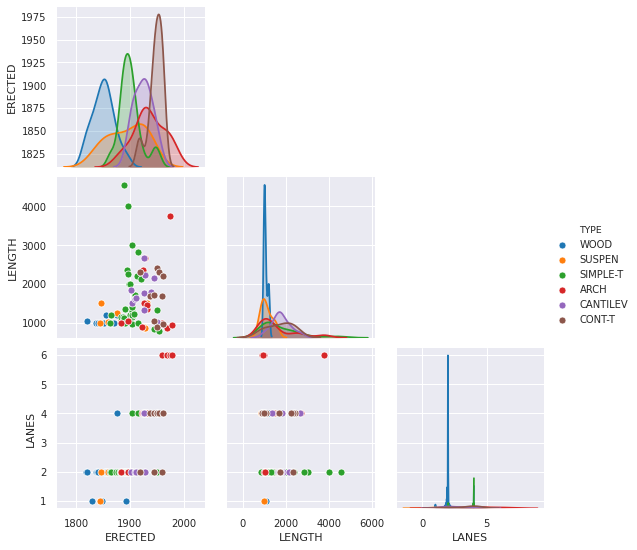

In [28]:
sns.set_style("darkgrid")

iris_plot_b = sns.pairplot(combined_b.drop(['LOCATION'], axis=1), hue='TYPE')
iris_plot_b.map_upper(hide_current_axis)
plt.show()

In [29]:
report_b = ProfileReport(combined_b)
report_b

En el reporte, no se obtiene correlación entre las variables dado la cantidad de ellas que son categoricas, salvo la correlación positiva entre **'LANES'** y **'ERECTED'**.

En el gráfico anterior podemos ver además cierta correlación entre esta última categoría y el tipo de material empleado.

### Preprocesamiento

En primer lugar, dado que existen filas donde el atríbuto principal **'TYPE'** es `NaN`, se opta por obviar las mismas. Se crea un nuevo dataframe, `df_b`, para realizar las tareas de preprocesamiento.

In [0]:
df_b = combined_b[combined_b.loc[:, 'TYPE'].notna()].copy()

Paso siguiente, se desea rellenar los `NaN` de las columnas **'LENGTH'** y **'LANES'**, de acuerdo al material del puente. 

Al cambiar el valor de esta última por la media del grupo, se la redondea.

In [0]:
df_b.loc[:,'LENGTH':'LANES'] = df_b.groupby(['MATERIAL'])\
.transform(lambda x: x.fillna(x.mean())).loc[:,'LENGTH':'LANES']

df_b.loc[:,'LANES'] = df_b.loc[:,'LANES'].round()

Se opta por transformar los datos de la columna **'MATERIAL'**, siendo esta la variable categórica que engloba a la principal (**'TYPE'**).

In [33]:
from sklearn.preprocessing import OneHotEncoder
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [8])], 
                                      remainder='passthrough')

aux =  pd.DataFrame(columnTransformer.fit_transform(df_b))
aux.columns = pd.Index(['IRON', 'STEEL', 'WOOD'])\
.append(combined_b.columns.drop('MATERIAL'))

df_b = aux.copy()
df_b.head(10)

,IRON,STEEL,WOOD,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,SPAN,REL-L,TYPE
0,0,0,1,M,3,1818,HIGHWAY,1057.67,2,N,THROUGH,SHORT,S,WOOD
1,0,0,1,A,25,1819,HIGHWAY,1037,2,N,THROUGH,SHORT,S,WOOD
2,0,0,1,A,39,1829,AQUEDUCT,1057.67,1,N,THROUGH,NaN,S,WOOD
3,0,0,1,A,29,1837,HIGHWAY,1000,2,N,THROUGH,SHORT,S,WOOD
4,0,0,1,M,23,1838,HIGHWAY,1057.67,2,N,THROUGH,NaN,S,WOOD
5,0,0,1,A,27,1840,HIGHWAY,990,2,N,THROUGH,MEDIUM,S,WOOD
6,1,0,0,A,28,1844,AQUEDUCT,1000,1,N,THROUGH,SHORT,S,SUSPEN
7,1,0,0,M,3,1846,HIGHWAY,1500,2,N,THROUGH,SHORT,S,SUSPEN
8,0,0,1,A,39,1848,AQUEDUCT,1057.67,1,N,DECK,NaN,S,WOOD
9,0,0,1,A,29,1851,HIGHWAY,1000,2,N,THROUGH,MEDIUM,S,WOOD


Finalmente, se realiza una codificación numérica sobre la variable categórica **'PURPOSE'**.

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

class_cat = df_b.loc[:,'PURPOSE']
class_cat_enc = encoder.fit_transform(class_cat)

df_b.loc[:,'PURPOSE'] = class_cat_enc
df_b.head()

,IRON,STEEL,WOOD,RIVER,LOCATION,ERECTED,PURPOSE,LENGTH,LANES,CLEAR-G,T-OR-D,SPAN,REL-L,TYPE
0,0,0,1,M,3,1818,1,1057.67,2,N,THROUGH,SHORT,S,WOOD
1,0,0,1,A,25,1819,1,1037,2,N,THROUGH,SHORT,S,WOOD
2,0,0,1,A,39,1829,0,1057.67,1,N,THROUGH,NaN,S,WOOD
3,0,0,1,A,29,1837,1,1000,2,N,THROUGH,SHORT,S,WOOD
4,0,0,1,M,23,1838,1,1057.67,2,N,THROUGH,NaN,S,WOOD


Siendo `df_b` el dataframe final. Y quedando la columna **'TYPE'** codificada como se indica mediante el siguiente diccionario.

In [35]:
purpose_dict = dict(enumerate(encoder.classes_))
purpose_dict

{0: 'AQUEDUCT', 1: 'HIGHWAY', 2: 'RR', 3: 'WALK'}